<a href="https://colab.research.google.com/github/amolaka/DS-3001---Voting-Project/blob/main/voting_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
! pip3 install mapclassify

In [27]:
# Import libraries and packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import mapclassify
from mpl_toolkits.axes_grid1 import make_axes_locatable

GOTTA FIGURE OUT HOW TO GET THIS WORKING

In [28]:
# Import files
#! git clone https://github.com/DS3001/project_voting
#gdf = gpd.read_file('VirginiaCounty_ClippedToShoreline.shx') # Load Virginia shapefile for maps
vdf = pd.read_csv('/content/project_voting/data/voting_VA.csv') # Load historical voting data
cdf = pd.read_csv('/content/project_voting/data/county_adjacencies.csv') # Load county adjacency data and population data

# Merge shapefile data and county adjacency data:
gdf['FIPS_left'] = pd.to_numeric(gdf['STCOFIPS'])
df = gdf.merge(cdf,left_on='FIPS_left',right_on='FIPS')  # merge county population and adjacency data into df
del gdf, cdf

NameError: name 'gdf' is not defined

In [29]:
# Import VA data
va_data = pd.read_csv('/content/project_voting/data/voting_VA.csv')
va_data = va_data.drop("Unnamed: 0", axis = 1)
va_data.head()

,year,state,state_po,county_name,county_fips,office,candidate,party,candidatevotes,totalvotes,version,mode
0,2000,VIRGINIA,VA,ACCOMACK,51001,US PRESIDENT,AL GORE,DEMOCRAT,5092,11925,20220315,TOTAL
1,2000,VIRGINIA,VA,ACCOMACK,51001,US PRESIDENT,GEORGE W. BUSH,REPUBLICAN,6352,11925,20220315,TOTAL
2,2000,VIRGINIA,VA,ACCOMACK,51001,US PRESIDENT,RALPH NADER,GREEN,220,11925,20220315,TOTAL
3,2000,VIRGINIA,VA,ACCOMACK,51001,US PRESIDENT,OTHER,OTHER,261,11925,20220315,TOTAL
4,2000,VIRGINIA,VA,ALBEMARLE,51003,US PRESIDENT,AL GORE,DEMOCRAT,16255,36846,20220315,TOTAL


In [30]:
# Drop NAs
va_data = va_data.dropna()

<Axes: >

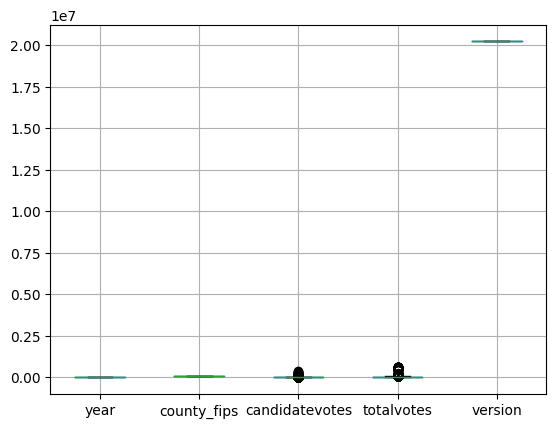

In [31]:
# Look at outliers
va_data.boxplot()

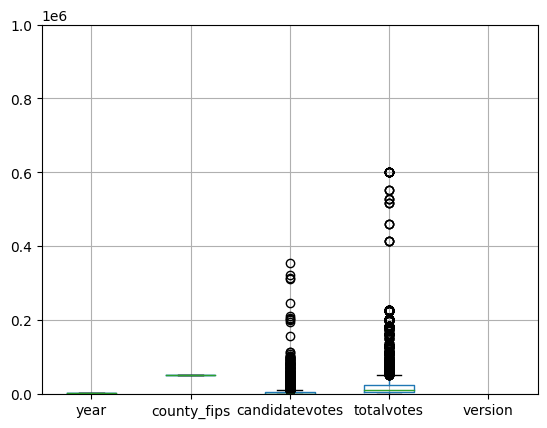

In [32]:
# Get a better view of outliers
va_data.boxplot()
plt.ylim(-1, 1000000)
plt.show()

In [33]:
# Log transformation
va_data['candidatevotes_log'] = np.log(va_data['candidatevotes'])
va_data['totalvotes_log'] = np.log(va_data['totalvotes'])

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: >

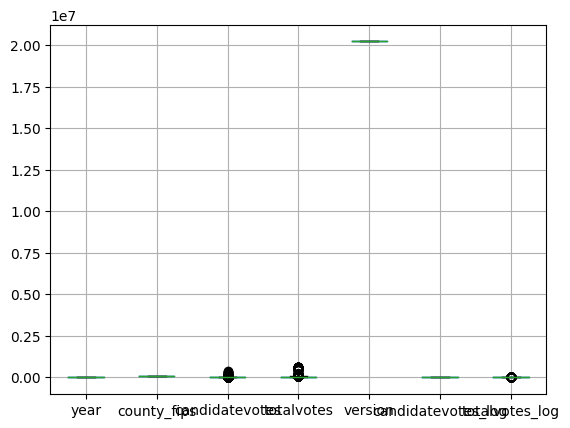

In [34]:
# View boxplots again
va_data.boxplot()

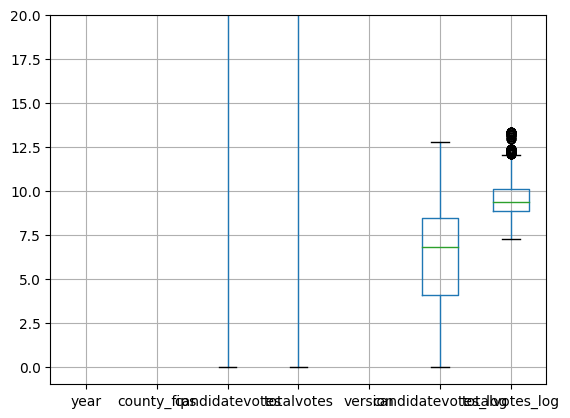

In [35]:
# Better view
va_data.boxplot()
plt.ylim(-1, 20)
plt.show()

# Much better!

In [36]:
# Look at the election votes for the years to determine best one for model
print(va_data['mode'].unique())
print(va_data['year'].unique())
modes_by_year = va_data.groupby('year')['mode'].unique()
print(modes_by_year)

# So only 2020 has all the different ways people voted, whereas the other years only have total
# 2020 is also the most recent with the same presidential candidates as this year, so use this

['TOTAL' 'ABSENTEE' 'ELECTION DAY' 'PROVISIONAL']
[2000 2004 2008 2012 2016 2020]
year
2000                                  [TOTAL]
2004                                  [TOTAL]
2008                                  [TOTAL]
2012                                  [TOTAL]
2016                                  [TOTAL]
2020    [ABSENTEE, ELECTION DAY, PROVISIONAL]
Name: mode, dtype: object


In [37]:
va_data = va_data[va_data['year'] == 2020]
va_data.head()

,year,state,state_po,county_name,county_fips,office,candidate,party,candidatevotes,totalvotes,version,mode,candidatevotes_log,totalvotes_log
2144,2020,VIRGINIA,VA,ACCOMACK,51001,US PRESIDENT,JOSEPH R BIDEN JR,DEMOCRAT,5495,16962,20220315,ABSENTEE,8.611594,9.738731
2145,2020,VIRGINIA,VA,ACCOMACK,51001,US PRESIDENT,JOSEPH R BIDEN JR,DEMOCRAT,2072,16962,20220315,ELECTION DAY,7.636270,9.738731
2146,2020,VIRGINIA,VA,ACCOMACK,51001,US PRESIDENT,JOSEPH R BIDEN JR,DEMOCRAT,11,16962,20220315,PROVISIONAL,2.397895,9.738731
2147,2020,VIRGINIA,VA,ACCOMACK,51001,US PRESIDENT,JO JORGENSEN,LIBERTARIAN,66,16962,20220315,ABSENTEE,4.189655,9.738731
2148,2020,VIRGINIA,VA,ACCOMACK,51001,US PRESIDENT,JO JORGENSEN,LIBERTARIAN,122,16962,20220315,ELECTION DAY,4.804021,9.738731


In [38]:
va_data['party'].unique()

array(['DEMOCRAT', 'LIBERTARIAN', 'OTHER', 'REPUBLICAN'], dtype=object)

In [66]:
# Group the data by 'county_name' and 'party' and sum the 'candidatevotes' column
votes = va_data.groupby(['county_name', 'party'])['candidatevotes'].sum().unstack(fill_value=0)

# Select only the columns for Democrat, Republican, and total votes
votes = votes[['DEMOCRAT', 'REPUBLICAN']]

# Aggregate the votes for each county
county_votes = votes.groupby('county_name').sum().reset_index()

# Merge with the total votes column
county_votes = county_votes.merge(va_data.groupby('county_name')['totalvotes'].first().reset_index(), on='county_name')

vdf = va_data.merge(votes, how='left', on='county_name')

In [70]:
vdf.rename(columns = {'DEMOCRAT': 'democrat_votes', 'REPUBLICAN': 'republican_votes', 'totalvotes': 'total_votes'}, inplace = True)
vdf.head()

,year,state,state_po,county_name,county_fips,office,candidate,party,candidatevotes,total_votes,version,mode,candidatevotes_log,totalvotes_log,democrat_votes,republican_votes
0,2020,VIRGINIA,VA,ACCOMACK,51001,US PRESIDENT,JOSEPH R BIDEN JR,DEMOCRAT,5495,16962,20220315,ABSENTEE,8.611594,9.738731,7578,9172
1,2020,VIRGINIA,VA,ACCOMACK,51001,US PRESIDENT,JOSEPH R BIDEN JR,DEMOCRAT,2072,16962,20220315,ELECTION DAY,7.636270,9.738731,7578,9172
2,2020,VIRGINIA,VA,ACCOMACK,51001,US PRESIDENT,JOSEPH R BIDEN JR,DEMOCRAT,11,16962,20220315,PROVISIONAL,2.397895,9.738731,7578,9172
3,2020,VIRGINIA,VA,ACCOMACK,51001,US PRESIDENT,JO JORGENSEN,LIBERTARIAN,66,16962,20220315,ABSENTEE,4.189655,9.738731,7578,9172
4,2020,VIRGINIA,VA,ACCOMACK,51001,US PRESIDENT,JO JORGENSEN,LIBERTARIAN,122,16962,20220315,ELECTION DAY,4.804021,9.738731,7578,9172


In [71]:
vdf = vdf[['year', 'state', 'county_name', 'county_fips', 'democrat_votes', 'republican_votes', 'total_votes']]

In [72]:
vdf

,year,state,county_name,county_fips,democrat_votes,republican_votes,total_votes
0,2020,VIRGINIA,ACCOMACK,51001,7578,9172,16962
1,2020,VIRGINIA,ACCOMACK,51001,7578,9172,16962
2,2020,VIRGINIA,ACCOMACK,51001,7578,9172,16962
3,2020,VIRGINIA,ACCOMACK,51001,7578,9172,16962
4,2020,VIRGINIA,ACCOMACK,51001,7578,9172,16962
...,...,...,...,...,...,...,...
1587,2020,VIRGINIA,WINCHESTER CITY,51840,6610,5221,12113
1588,2020,VIRGINIA,WINCHESTER CITY,51840,6610,5221,12113
1589,2020,VIRGINIA,WINCHESTER CITY,51840,6610,5221,12113
1590,2020,VIRGINIA,WINCHESTER CITY,51840,6610,5221,12113


In [73]:
# Import county adjacencies data
county_adjacencies = pd.read_csv('/content/project_voting/data/county_adjacencies.csv')
county_adjacencies.head()

,County,Population2022,FIPS,District,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,N11,N12
0,Accomack,33191,51001,2,Northumberland,Lancaster,Middlesex,Mathews,Northampton,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Albemarle,114534,51003,5,CharlottesvilleCity,Nelson,Augusta,Rockingham,Greene,Orange,Louisa,Fluvanna,Buckingham,Nelson,NaN,NaN
2,AlexandriaCity,155525,51510,8,Fairfax,Arlington,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Alleghany,14835,51005,6,Craig,Bath,Botetourt,CovingtonCity,Rockbridge,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Amelia,13455,51007,5,PrinceEdward,Cumberland,Powhatan,Chesterfield,Dinwiddie,Nottoway,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
# Drop NAs
county_adjacencies = county_adjacencies.dropna()

<Axes: >

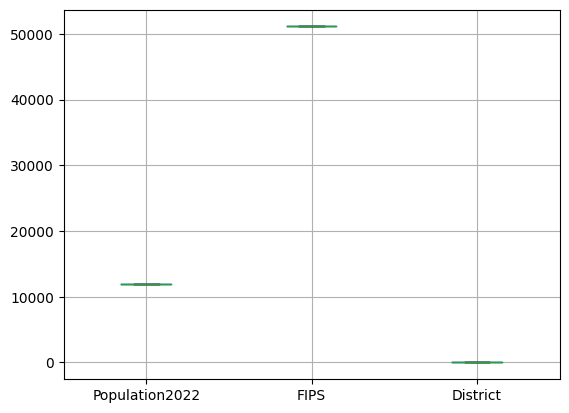

In [75]:
# Look at outliers
county_adjacencies.boxplot()
# Looks good!